<a href="https://colab.research.google.com/github/igorrivin/spacecurves/blob/main/segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cmath

In [ ]:
from sortedcontainers import SortedKeyList
from itertools import cycle

In [ ]:
def rank_two(v0, r, s):
  v0c = complex(v0[0], v0[1])
  rc = complex(r[0], r[1])
  sc = complex(s[0], s[1])
  pr = cmath.phase(rc/v0c)
  if pr > 0:
    return [1, 3]
  return [3, 1]

In [ ]:
class Segment:
  def __init__(self, beg, end):
    self.beg = beg
    self.end = end
    self.vec = end - beg
    self.crossings = SortedKeyList(key=self.get_val)

  def get_val(self, crossing):
    if crossing.seg1 == self:
      return crossing.t1
    return crossing.t2

  def length(self):
    return np.linalg.norm(self.vec)

  def project(self, mat):
    newbeg = mat @ beg
    newend = mat @ end
    return Segment(newbeg, newend)

  def traverse(self, beg):
    if len(self.crossings) == 0:
      return beg
    for i, c in enumerate(self.crossings, beg):
      c.DTcode = i
    return beg + len(self.crossings)

  def __repr__(self):
    return str(self.beg) + " " + str(self.end)


In [ ]:
def intersections(seg1, seg2):
  if seg1 == seg2:
    return None
  if np.array_equal(seg1.beg, seg2.end) or np.array_equal(seg2.beg, seg1.end):
    return None
  p = seg1.beg[0:2]
  r = seg1.vec[0:2]
  q = seg2.beg[0:2]
  s = seg2.vec[0:2]
  diff1 = q - p
  cross1 = np.linalg.det(np.vstack((diff1, s)))
  cross2 = np.linalg.det(np.vstack((r, s)))
  cross3 = np.linalg.det(np.vstack((diff1, r)))
  if cross2 == 0 and cross3 == 0:
    raise Exception('collinear')
  if cross2 == 0:
    return None
  t = cross1 / cross2
  if t < 0 or t > 1:
    return None
  u = cross3/cross2
  if u < 0 or u > 1:
    return None
  return t, u
    


In [ ]:
class Crossing:
  def are_same(c1, c2):
    return c1.seg1 == c2.seg2 and c1.seg2 == c2.seg1

  def __init__(self, seg1, seg2, ind1=0, ind2=0, comp1=0, comp2=0):
    self.seg1 = seg1
    self.seg2 = seg2
    self.ind1 = ind1
    self.ind2 = ind2
    self.comp1 = comp1
    self.comp2 = comp2
    inter = intersections(seg1, seg2)
    if inter is None:
      self.over = None
      return
    #print(seg1, seg2, inter)
    a = inter[0]
    b = inter[1]
    z1 = (seg1.beg + a * seg1.vec)[2]
    z2 = (seg2.beg + b * seg2.vec)[2]
    if z1 == z2:
      raise Exception('not embedded, seg1 was {0}, seg2 was {1}'.format(seg1, seg2))
    self.t1 = a
    self.t2 = b
    seg1.crossings.add(self)
    #seg2.crossings.add(self)
    if z1 > z2:
      self.over = True
    else:
      self.over = False
    self.cyclic_order = self.cyclic_o()
    self.DTcode = None
    self.thehash = self.get_hash()
    
  def cyclic_o(self):
    c_dict = {}
    def get_c_dict(s1, s2):
      c_dict = {}
      c_dict[0] = (s1, "beg")
      c_dict[2] = (s1, "end")
      r = rank_two(s1.beg, s2.beg, s2.end)
      if r[0] == 1:
        c_dict[1] = (s2, "beg")
        c_dict[3] = (s2, "end")
      else:
        c_dict[1] = (s2, "end")
        c_dict[3] = (s2, "beg")
      return c_dict
    if self.over is False:
      return get_c_dict(self.seg1, self.seg2)
    else:
      return get_c_dict(self.seg2, self.seg1)

  def get_hash(self):
    h1 = hash(self.seg1)
    h2 = hash(self.seg2)
    if h1 < h2:
      return hash((self.seg1, self.seg2))
    return hash((self.seg2, self.seg1))


    

In [ ]:
class PLCurve:
  def __init__(self, pointlist, isClosed):
    self.pointlist = pointlist
    ll = len(self.pointlist)
    preseglist = [Segment(pointlist[i], pointlist[i+1])for i in range(ll-1)]
    if isClosed is False:
      self.seglist = preseglist
    else:
      preseglist.append(Segment(pointlist[ll-1], pointlist[0]))
      self.seglist = preseglist

  def length(self):
    return sum([x.length() for x in seglist])
  
  def DTtraverse(self, beg):
    newbeg = beg
    for seg in self.seglist:
      newbeg = seg.traverse(newbeg)
    return newbeg



  


In [ ]:
class Link:
  def __init__(self, curvelist):
    self.curvelist = curvelist
    self.crossings = []
    self.makeAllCrossings()
    beg = 1
    for c in self.curvelist:
      beg  = c.DTtraverse(beg)
    self.crossings.sort(key=lambda x: x.thehash)
    self.DTcode = dtCode(self.crossings)

  def makeCrossings(self, curve1, curve2, comp1, comp2):
    for i, seg1 in enumerate(curve1.seglist):
      for j, seg2 in enumerate(curve2.seglist):
        newcross = Crossing(seg1, seg2, i, j, comp1, comp2)
        if newcross.over is not None:
          self.crossings.append(newcross)
      #return sorted(crossings, key = lambda x: x.thehash) not quite right

  def makeAllCrossings(self):
    for i, c in enumerate(self.curvelist):
      for j, d in enumerate(self.curvelist):
        self.makeCrossings(c, d, i, j)
    


In [ ]:
def dtCode(crossings):
  def dtpair(c1, c2):
    code1 = c1.DTcode
    code2 = c2.DTcode
    if code1%2 == code2%2:
      raise Exception("Goofy crossings")
    if code1%2 == 0:
      thecode = code1
      othercode = code2
      cc = c1
    else:
      thecode = code2
      othercode = code1
      cc = c2
    if cc.over is True:
      return (othercode, -thecode)
    else:
      return (othercode, thecode)
  codelist = []
  for i in range(0, len(crossings), 2):
    codelist.append(dtpair(crossings[i], crossings[i+1]))
  return [x[1] for x in sorted(codelist)]

In [ ]:
def randfunc(stepsize, ll, decayfunc):
  sigmas = np.array(list(map(decayfunc, range(ll))))
  sincoeffs0 = np.random.randn(ll)
  sincoeffs = sincoeffs0 * sigmas
  coscoeffs0 = np.random.randn(ll)
  coscoeffs = coscoeffs0 * sigmas
  def rf(x):
    sinpoly = 0
    cospoly = 0
    for i in range(ll):
      sinpoly += sincoeffs[i] * np.sin(i * x)
      cospoly += coscoeffs[i] * np.cos(i * x)
    return sinpoly + cospoly
  return np.array(list(map(rf, np.arange(0, 2*np.pi, stepsize))))

In [ ]:
rdog = randfunc(0.1, 4, lambda x: 1/(x+1))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def rknot(stepnum, ll, decayfunc):
  xvals = randfunc(stepnum, ll, decayfunc)
  yvals = randfunc(stepnum, ll, decayfunc)
  zvals = randfunc(stepnum, ll, decayfunc)
  return np.vstack((xvals, yvals, zvals)).T

In [ ]:
dogk= rknot(0.1, 20, lambda x: x)

In [ ]:
dogk

array([[ 1.44382758e+01,  1.87099537e+01,  5.57639185e+00],
       [ 1.43866289e+01,  1.54603081e+01,  4.65472523e+01],
       [ 7.10231652e-01, -5.71844452e+01, -2.74311388e+00],
       [-9.36847707e+00, -1.93490656e+01, -4.33391842e+01],
       [-1.90500419e+01,  7.34813547e+01, -1.00777877e+01],
       [ 2.74425317e+01,  2.25110319e+01,  3.02871170e+01],
       [ 3.19103721e+01, -5.68769774e+01,  3.72585532e+01],
       [-5.47757817e+01, -8.86084628e-01, -1.15551123e+01],
       [-2.60420142e+01,  2.24129136e+01, -7.21598326e+01],
       [ 1.00523582e+02, -7.41866116e+01, -2.02794202e+01],
       [ 4.48766401e+01, -6.91171548e+01,  7.19105223e+01],
       [-8.69737629e+01,  5.47041956e+01,  2.04340208e+01],
       [-2.46929741e+01,  6.02141354e+01, -5.37890713e+01],
       [ 3.68487627e+01, -1.61870658e+01,  1.97991860e+01],
       [-6.67734866e+01,  9.57179392e+00,  5.76347014e+01],
       [-5.16321712e+01,  3.04480001e+01, -4.51612369e+01],
       [ 9.97809449e+01, -5.56882661e+01

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dogk = np. vstack([np.array([ 35.46863002,  91.5681188 , -13.891288  ]),
 np.array([-104.13666323,   16.17009024,    5.384612  ]),
 np.array([ 70.80366358, -87.97930647,   5.384612  ]),
 np.array([ 53.98683132,  67.08302562, -13.891288  ]),
 np.array([-87.8186563 , -13.63626943,   8.506676  ]),
 np.array([  39.19228214, -101.18134095,    8.506676  ])])

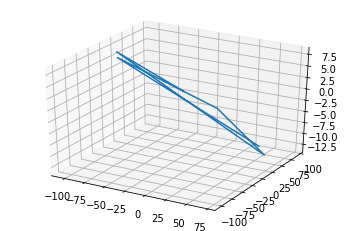

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(dogk[:, 0], dogk[:, 1], dogk[:,2])

In [ ]:
dogk[:, 0]

In [ ]:
foo = PLCurve(dogk, isClosed=True)

In [ ]:
newlink = Link([foo])

In [ ]:
newlink.DTcode

[-4, -6, -2]

In [ ]:
print('Link(\"DT')

In [ ]:
def snaplink(l):
  relist = [tuple(l)]
  return 'Link(\"DT: ' + str(relist) + '\")'

In [ ]:
snaplink(newlink.DTcode)

'Link("DT: [(-4, -6, -2)]")'

In [ ]:
def rank_simple(vector ):
    return sorted(range(len(vector)), key=vector.__getitem__)

In [ ]:
def rank_vecs(v0, r, s, t):
  v0c = complex(v0[0], v0[1])
  rc = complex(r[0], r[1])
  sc = complex(s[0], s[1])
  tc = complex(t[0], t[1])
  pr = cmath.phase(rc/v0c)
  ps = cmath.phase(sc/v0c)
  pt = cmath.phase(tc/v0c)
  if pr < 0:
    pr = 2 * np.pi + pr
  if ps < 0:
    ps = 2 * np.pi + ps
  if pt < 0:
    pt = 2 * np.pi + pt
  theranks0 = rank_simple([pr, ps, pt])
  return [1+x for x in theranks0]




In [ ]:
!pip install pyknotid

In [ ]:
from pyknotid.spacecurves import Knot

In [ ]:
foo = Knot(dogk)

In [ ]:
from pyknotid.invariants import *

In [ ]:
foo.alexander_polynomial()

In [ ]:
!pip install PyQt5